# Laboratorio 4: Implementación de pipeline RAG avanzado

En este laboratorio, implementaremos un pipeline RAG (Retrieval-Augmented Generation) completo utilizando LangChain y Pinecone. Exploraremos técnicas avanzadas de preprocesamiento, chunking, retrievers y optimización de contextos.

**Objetivos de aprendizaje:**
- Construir un pipeline RAG básico con LangChain
- Implementar técnicas de preprocesamiento de texto
- Explorar diferentes estrategias de chunking
- Utilizar retrievers avanzados y filtros de metadata
- Aplicar reordenamiento de contextos para evitar "Lost in the Middle"



## Parte 1: Setup y pipeline RAG básico

Comenzaremos configurando el entorno y creando un pipeline RAG básico que servirá como base para las mejoras posteriores.

In [ ]:
# Instalar dependencias
%pip install langchain langchain-community langchain-pinecone sentence-transformers spacy langchain-huggingface pypdf

# Descargar modelo de español para preprocesamiento
!python -m spacy download es_core_news_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.5/323.5 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 127.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_pinecone import PineconeVectorStore
from langchain_huggingface import ChatHuggingFace
from langchain.schema import Document
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain_community.document_transformers import LongContextReorder
import spacy
import re
from sentence_transformers import SentenceTransformer
import numpy as np
from google.colab import userdata

/usr/local/lib/python3.12/dist-packages/langchain_pinecone/__init__.py:3: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langchain_pinecone.vectorstores import Pinecone, PineconeVectorStore


In [ ]:
from langchain_community.document_loaders import PyPDFLoader
pdf_path = "/content/1706.03762v7.pdf"
loader = PyPDFLoader(pdf_path)
docs = loader.load()
print(f"Documentos cargados del PDF: {len(docs)}")
print(f"Primera página: {docs[0].page_content[:200]}...")

Documentos cargados del PDF: 15
Primera página: Provided proper attribution is provided, Google hereby grants permission to
reproduce the tables and figures in this paper solely for use in journalistic or
scholarly works.
Attention Is All You Need
...


In [ ]:
# Configurar embeddings and LLM
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

# Using ChatHuggingFace for the LLM
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint

model_id = "Qwen/Qwen3-4B-Instruct-2507"

llm = HuggingFaceEndpoint(
    repo_id=model_id,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
    provider="auto",  # let Hugging Face choose the best provider for you
)

chat_model = ChatHuggingFace(llm=llm)


# Chunking básico
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50
)

chunks = text_splitter.split_documents(docs)


print(f"Documentos originales: {len(docs)}")
print(f"Chunks generados: {len(chunks)}")
print(f"Tamaño promedio de chunk: {sum(len(c.page_content) for c in chunks) / len(chunks):.0f} caracteres")

Documentos originales: 15
Chunks generados: 93
Tamaño promedio de chunk: 433 caracteres


In [ ]:
# Crear vector store en Pinecone
from pinecone import Pinecone
import os
from pinecone import ServerlessSpec
pc = Pinecone(api_key=userdata.get('PINECONE_API_KEY'))
os.environ["PINECONE_API_KEY"] = userdata.get("PINECONE_API_KEY")


index_name = "rag-basic"
pc.create_index(
  name=index_name,
  dimension=384,
  metric="cosine",
  spec=ServerlessSpec(
    cloud="aws",
    region="us-east-1"
  )
)

print(f"Index '{index_name}' created.")

vectorstore = PineconeVectorStore.from_documents(
    chunks,
    embeddings,
    index_name="rag-basic"
)

Index 'rag-basic' created.


In [ ]:
# Manually retrieve documents and pass to LLM

test_query_manual = "Whats attention?"

retrieved_docs = vectorstore.as_retriever(k=3).get_relevant_documents(test_query_manual)
print("Primeros 15 caracteres de cada documento:")
for i, doc in enumerate(retrieved_docs, start=1):
    preview = doc.page_content[:15].replace("\n", " ")
    print(f"  Documento {i}: {preview}...")

context = "\n".join([doc.page_content for doc in retrieved_docs])

prompt_template = """Using the following context, answer the question.

Context:
{context}

Question:
{question}

Answer:
"""

formatted_prompt = prompt_template.format(context=context, question=test_query_manual)
print(formatted_prompt)


Primeros 15 caracteres de cada documento:
  Documento 1: masking, combin...
  Documento 2: . <EOS> <pad> <...
  Documento 3: reduced to a co...
  Documento 4: but its applica...
Using the following context, answer the question.

Context:
masking, combined with fact that the output embeddings are offset by one position, ensures that the
predictions for position i can depend only on the known outputs at positions less than i.
3.2 Attention
An attention function can be described as mapping a query and a set of key-value pairs to an output,
where the query, keys, values, and output are all vectors. The output is computed as a weighted sum
3
.
<EOS>
<pad>
<pad>
<pad>
<pad>
<pad>
<pad>
Figure 3: An example of the attention mechanism following long-distance dependencies in the
encoder self-attention in layer 5 of 6. Many of the attention heads attend to a distant dependency of
the verb ‘making’, completing the phrase ‘making...more difficult’. Attentions here shown only for
the word ‘making’.

In [ ]:
try:
    response_manual = chat_model.invoke(formatted_prompt)
    print(f"Pregunta: {test_query_manual}")
    print(f"Respuesta (Manual): {response_manual}")

    without_context=chat_model.invoke("Whats attention?")
    print(f"Respuesta sin contexto: {without_context}")
except Exception as e:
    print(f"An error occurred when invoking the LLM: {e}")
    print("Please check the LLM object and its invocation method.")

Pregunta: Whats attention?
Respuesta (Manual): content='Attention is a mechanism that maps a query and a set of key-value pairs to an output, where the output is computed as a weighted sum of the values. In the context of sequences, self-attention allows different positions within a single sequence to interact with each other, enabling the model to weigh the importance of different elements when computing a representation of the sequence. This helps the model capture relationships and dependencies between elements, even if they are far apart in the sequence, improving its ability to understand context and meaning.' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 103, 'prompt_tokens': 414, 'total_tokens': 517}, 'model_name': 'Qwen/Qwen3-4B-Instruct-2507', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run--7ae5b368-bc8e-4b0f-b6a3-a2b5102439d2-0' usage_metadata={'input_tokens': 414, 'output_tokens': 103, 'total_tokens': 517}
Respue

## Parte 2: Preprocesamiento de Texto y Chunking

### Preprocesamiento de Texto

El preprocesamiento de texto es crucial para mejorar la calidad de los embeddings. Según las mejores prácticas, implementaremos:

1. **Lematización**: Reducir palabras a su forma raíz
2. **Expansión de abreviaturas**: Convertir abreviaciones a formas completas
3. **Eliminación de stopwords**: Remover palabras sin significado semántico
4. **Normalización**: Limpiar caracteres especiales y espacios

Estas técnicas mejoran la capacidad de coincidencia semántica y reducen el ruido en los embeddings.

In [ ]:
nlp = spacy.load('en_core_web_sm')
print("Modelo de inglés cargado exitosamente")

Modelo de inglés cargado exitosamente


In [ ]:
def prepare_text_for_embeddings(content_str):
    """Preprocesar texto para mejorar calidad de embeddings"""
    if content_str is None or content_str.strip() == "":
        return "N/A"

    content_str = re.sub(r'\W', ' ', content_str)

    doc = nlp(content_str.lower())
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop]

    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text if lemmatized_text.strip() else "N/A"

def expand_abbreviations(text):
    """Expandir abreviaturas comunes"""
    if text is None or text.strip() == "":
        return "N/A"

    abbreviations = {
        "LLM": "Large Language Model",
        "RAG": "Retrieval-Augmented Generation",
        "SLM": "Small Language Model",
        "HNSW": "Hierarchical Navigable Small Worlds",
        "MMR": "Maximal Marginal Relevance",
        "BERT": "Bidirectional Encoder Representations from Transformers",
        "GPT": "Generative Pre-trained Transformer",
        "NLP": "Natural Language Processing",
        "ML": "Machine Learning",
        "AI": "Artificial Intelligence"
    }
    for abbr, full in abbreviations.items():
        text = re.sub(r'\b{}\b'.format(abbr), full, text)
    return text

def normalize_text(s, sep_token = " \n "):
    """Normalizar texto para consistencia"""
    if s is None or s.strip() == "":
        return "N/A"

    s = re.sub(r'\s+',  ' ', s).strip()
    s = re.sub(r". ,","",s)
    s = s.replace("..",".")
    s = s.replace(". .",".")
    s = s.replace("\n", "")
    s = s.strip()

    if not s:
        return "N/A"
    return s

print("Funciones de preprocesamiento definidas")

Funciones de preprocesamiento definidas


In [ ]:
processed_chunks = []
for i, chunk in enumerate(chunks):
    # Get the page_content from the chunk
    original_text = chunk.page_content

    # Apply ALL preprocessing steps
    processed_text = prepare_text_for_embeddings(
        normalize_text(
            expand_abbreviations(original_text)
        )
    )

    # Create a new Document with processed content
    processed_chunk = Document(
        page_content=processed_text,
        metadata=chunk.metadata  # Keep original metadata
    )
    processed_chunks.append(processed_chunk)

    if i < 2:
        print(f"\nChunk {i+1}:")
        print(f"Original: {original_text[:100]}...")
        print(f"Procesado: {processed_text[:100]}...")

print(f"\nProcesamiento completado: {len(processed_chunks)} chunks procesados")

# Show the text improvement
print("=== COMPARACIÓN DE CALIDAD DE TEXTO ===")
for i in range(min(3, len(chunks))):
    original = chunks[i].page_content
    processed = processed_chunks[i].page_content

    print(f"\nChunk {i+1}:")
    print(f"Original: {original[:150]}...")
    print(f"Procesado: {processed[:150]}...")

    # Check for actual improvements
    improvements = []
    if len(processed) < len(original):
        improvements.append("✓ Stopwords removidas")
    if processed != original:
        improvements.append("✓ Lemmatización aplicada")
    if "Large Language Model" in processed and "LLM" in original:
        improvements.append("✓ Abreviaciones expandidas")




Chunk 1:
Original: Provided proper attribution is provided, Google hereby grants permission to
reproduce the tables and...
Procesado: provide proper attribution provide   google grant permission reproduce table figure paper solely use...

Chunk 2:
Original: University of Toronto
aidan@cs.toronto.edu
Łukasz Kaiser∗
Google Brain
lukaszkaiser@google.com
Illia...
Procesado: university toronto aidan cs toronto edu łukasz kaiser   google brain lukaszkaiser google com illia p...

Procesamiento completado: 93 chunks procesados
=== COMPARACIÓN DE CALIDAD DE TEXTO ===

Chunk 1:
Original: Provided proper attribution is provided, Google hereby grants permission to
reproduce the tables and figures in this paper solely for use in journalis...
Procesado: provide proper attribution provide   google grant permission reproduce table figure paper solely use journalistic scholarly work   attention need ashi...

Chunk 2:
Original: University of Toronto
aidan@cs.toronto.edu
Łukasz Kaiser∗
Google Brain
luka

### Estrategias de Chunking

El chunking es uno de los pasos más críticos en RAG. Diferentes estrategias tienen diferentes ventajas:

1. **Chunks pequeños (200-300 caracteres)**: Más precisos, mejor para preguntas específicas
2. **Chunks medianos (500-800 caracteres)**: Balance entre precisión y contexto
3. **Chunks grandes (1000+ caracteres)**: Más contexto, mejor para preguntas complejas y estructuras com tablas, pero mayores costos y rellenas mas rapido la ventana de contexto

El overlap es crucial para evitar pérdida de información en los límites de los chunks. Un overlap del 10-20% del tamaño del chunk suele ser óptimo.

**Consideraciones importantes:**
- Chunks muy pequeños pueden perder contexto importante
- Chunks muy grandes pueden causar "Lost in the Middle":
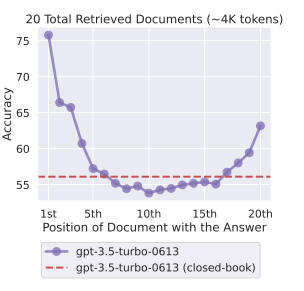
- El tamaño óptimo depende del tipo de consultas esperadas
- Para tablas largas, considerar Parent Document Retriever
- Para documentos cortos (como CVs), no chunking puede ser mejor

In [ ]:
# Comparar diferentes estrategias de chunking
chunking_strategies = {
    "chunks_pequeños": RecursiveCharacterTextSplitter(
        chunk_size=200, chunk_overlap=20
    ),
    "chunks_medianos": RecursiveCharacterTextSplitter(
        chunk_size=500, chunk_overlap=50
    ),
    "chunks_grandes": RecursiveCharacterTextSplitter(
        chunk_size=1000, chunk_overlap=100
    )
}

# Analizar cada estrategia usando los chunks procesados
chunking_results = {}
for strategy_name, splitter in chunking_strategies.items():
    chunks = splitter.split_documents(processed_chunks)  # Use processed_chunks instead
    chunking_results[strategy_name] = {
        "chunk_count": len(chunks),
        "avg_chunk_size": sum(len(c.page_content) for c in chunks) / len(chunks),
        "chunks": chunks
    }
    print(f"{strategy_name}: {len(chunks)} chunks, tamaño promedio: {chunking_results[strategy_name]['avg_chunk_size']:.0f} caracteres")

print("\nEjemplo de chunks medianos:")
for i, chunk in enumerate(chunking_results["chunks_medianos"]["chunks"][:2]):
    print(f"\nChunk {i+1}:")
    print(f"{chunk.page_content[:150]}...")

chunks_pequeños: 207 chunks, tamaño promedio: 161 caracteres
chunks_medianos: 93 chunks, tamaño promedio: 340 caracteres
chunks_grandes: 93 chunks, tamaño promedio: 340 caracteres

Ejemplo de chunks medianos:

Chunk 1:
provide proper attribution provide   google grant permission reproduce table figure paper solely use journalistic scholarly work   attention need ashi...

Chunk 2:
university toronto aidan cs toronto edu łukasz kaiser   google brain lukaszkaiser google com illia polosukhin     illia polosukhin gmail com abstract ...


## Parte 3: Metadata y Retrievers Avanzados

### Agregado de Metadata

La metadata es crucial para mejorar la precisión de las búsquedas. Permite:

1. **Filtrado por tema**: Buscar solo en documentos relevantes
2. **Filtrado por dificultad**: Adaptar respuestas al nivel del usuario
3. **Trazabilidad**: Mostrar fuente original del documento
4. **Navegación**: Enlazar al documento original

**Ejemplos de metadata útiles:**
- `source`: Archivo original
- `page`: Número de página
- `section`: Sección del documento
- `topic`: Tema principal
- `difficulty`: Nivel de complejidad
- `timestamp`: Fecha de creación/modificación

In [ ]:
documents_with_metadata = []
for i, chunk in enumerate(processed_chunks):
    # Determinar tema basado en contenido
    content = chunk.page_content.lower()
    if "chunking" in content or "splitter" in content:
        topic = "chunking"
    elif "retriever" in content or "búsqueda" in content or "search" in content:
        topic = "retrieval"
    elif "vector" in content or "embedding" in content:
        topic = "vector_db"
    elif "contexto" in content or "reorder" in content or "attention" in content:
        topic = "context"
    elif "transformer" in content or "neural" in content:
        topic = "neural_networks"
    elif "machine" in content or "learning" in content:
        topic = "machine_learning"
    else:
        topic = "general"

    # Flatten metadata - only keep simple values
    doc_with_meta = Document(
        page_content=chunk.page_content,
        metadata={
            "source": f"transformer_paper_{i}",
            "topic": topic,
            "difficulty": ["beginner", "intermediate", "advanced"][i % 3],
            "length": len(chunk.page_content),
            "doc_id": i,
            "page": chunk.metadata.get("page", i),
            "pdf_source": chunk.metadata.get("source", ""),
            "creator": chunk.metadata.get("creator", ""),
            "creation_date": chunk.metadata.get("creationdate", "")
        }
    )
    documents_with_metadata.append(doc_with_meta)


In [ ]:

# Create a new index for metadata version
index_name_metadata = "rag-with-metadata"
pc.create_index(
  name=index_name_metadata,
  dimension=384,
  metric="cosine",
  spec=ServerlessSpec(
    cloud="aws",
    region="us-east-1"
  )
)

print(f"Index '{index_name_metadata}' created.")

# Now create the vector store with metadata
vectorstore_with_metadata = PineconeVectorStore.from_documents(
    documents_with_metadata,
    embeddings,
    index_name="rag-with-metadata"
)

print(f"\nVector store con metadata creado: {len(documents_with_metadata)} documentos")

Index 'rag-with-metadata' created.

Vector store con metadata creado: 93 documentos


In [ ]:
# Simple Comparison: Filtered vs Unfiltered
query = "transformer architecture"

print("=== COMPARACIÓN: Con vs Sin Filtros ===")
print(f"Query: '{query}'")
print()

# SIN FILTRO
print("1. SIN FILTRO:")
no_filter = vectorstore_with_metadata.similarity_search(query, k=3)
for i, doc in enumerate(no_filter, 1):
    print(f"   {i}. Topic: {doc.metadata['topic']} | Difficulty: {doc.metadata['difficulty']}")

print()

# CON FILTRO
print("2. CON FILTRO (solo neural_networks):")
with_filter = vectorstore_with_metadata.similarity_search(
    query,
    k=3,
    filter={"topic": "neural_networks"}
)
for i, doc in enumerate(with_filter, 1):
    print(f"   {i}. Topic: {doc.metadata['topic']} | Difficulty: {doc.metadata['difficulty']}")

=== COMPARACIÓN: Con vs Sin Filtros ===
Query: 'transformer architecture'

1. SIN FILTRO:
   1. Topic: neural_networks | Difficulty: advanced
   2. Topic: neural_networks | Difficulty: beginner
   3. Topic: context | Difficulty: beginner

2. CON FILTRO (solo neural_networks):
   1. Topic: neural_networks | Difficulty: advanced
   2. Topic: neural_networks | Difficulty: beginner
   3. Topic: neural_networks | Difficulty: beginner


## Parte 4: Reordenamiento de Contextos y Optimización

### El Problema "Lost in the Middle"

Los modelos de lenguaje basados en transformers tienen una limitación conocida: prestan más atención al inicio y final del contexto, perdiendo información en el medio. Esto es especialmente problemático en RAG cuando se recuperan múltiples documentos.

**Solución: Long-Context Reorder**

Esta técnica reordena los documentos recuperados para optimizar la atención del modelo:
1. **Documento más relevante**: Al inicio
2. **Documentos menos relevantes**: Al final
3. **Documentos de relevancia media**: En el medio

Esto mejora significativamente la calidad de las respuestas, especialmente con contextos largos.

In [ ]:
# Implementar Long-Context Reorder
from langchain_community.document_transformers import LongContextReorder

reordering = LongContextReorder()

# Probar con tu vector store existente
query = "¿Cómo funciona RAG y qué técnicas de chunking utiliza?"
results = vectorstore_with_metadata.similarity_search(query, k=5)

print(f"Consulta: {query}")
print(f"\nOrden original ({len(results)} documentos):")
for i, doc in enumerate(results):
    print(f"  {i+1}. [{doc.metadata['topic']}] {doc.page_content[:60]}...")

# Aplicar reordenamiento
reordered_docs = reordering.transform_documents(results)
print(f"\nReordenado ({len(reordered_docs)} documentos):")
for i, doc in enumerate(reordered_docs):
    print(f"  {i+1}. [{doc.metadata['topic']}] {doc.page_content[:60]}...")

print("\nReordenamiento completado - documentos más relevantes al inicio y final")

Consulta: ¿Cómo funciona RAG y qué técnicas de chunking utiliza?

Orden original (5 documentos):
  1. [general] sentence pair   sentence encode byte pair encode    3    sha...
  2. [neural_networks] arxiv 1607 06450   2016    2   dzmitry bahdanau   kyunghyun ...
  3. [neural_networks] 2006    30   ofir press lior wolf   output embed improve lan...
  4. [neural_networks]   37   vinyal    kaiser   koo   petrov   sutskever   hinton ...
  5. [context] application    missin opinion     eos    pad   figure 4   at...

Reordenado (5 documentos):
  1. [general] sentence pair   sentence encode byte pair encode    3    sha...
  2. [neural_networks] 2006    30   ofir press lior wolf   output embed improve lan...
  3. [context] application    missin opinion     eos    pad   figure 4   at...
  4. [neural_networks]   37   vinyal    kaiser   koo   petrov   sutskever   hinton ...
  5. [neural_networks] arxiv 1607 06450   2016    2   dzmitry bahdanau   kyunghyun ...

Reordenamiento completado - document

### Optimización de Parámetros

**Parámetro K (Número de documentos recuperados)**

El parámetro K es crucial para el rendimiento:
- **K bajo (1-3)**: Mayor precisión, menos contexto
- **K medio (3-5)**: Balance entre precisión y cobertura
- **K alto (5-10)**: Mayor cobertura, posible ruido

**Técnicas de Reranking**

1. **MMR (Maximal Marginal Relevance)**: Diversifica resultados
2. **Reranking basado en relevancia**: Prioriza documentos más relevantes
3. **Threshold vs. Top-K**: Usar umbral de similitud o número fijo

**Estrategias de optimización:**
- Probar diferentes valores de K
- Evaluar métricas de precisión y recall
- Considerar el tipo de consultas esperadas
- Balancear velocidad vs. calidad

In [ ]:
# Test K values and MMR reranking
test_query = "What is attention mechanism?"
print(f"Query: {test_query}")
print("="*50)

# 1. Test K values (precision vs recall)
print("1. K VALUES:")
k_values = [1, 3, 5]
for k in k_values:
    docs = vectorstore_with_metadata.similarity_search(test_query, k=k)
    context = "\n".join([doc.page_content for doc in docs])
    prompt = f"Context: {context}\n\nQuestion: {test_query}\n\nAnswer:"
    response = chat_model.invoke(prompt)
    print(f"  K={k}: {len(str(response))} chars")

print("\n" + "="*50)

# 2. Test MMR reranking (diversification)
print("2. MMR RERANKING:")
mmr_results = vectorstore_with_metadata.similarity_search_with_relevance_scores(
    test_query,
    k=5,
    fetch_k=10  # More candidates for MMR
)
print(f"  MMR: {len(mmr_results)} docs with scores")
for i, (doc, score) in enumerate(mmr_results):
    print(f"    {i+1}. Score: {score:.3f} - {doc.metadata['topic']}")

print("\n" + "="*50)
print("SUMMARY:")
print("K=1: High precision, low recall")
print("K=5: Balanced precision/recall")
print("MMR: Diversifies results, reduces redundancy")

Query: What is attention mechanism?
1. K VALUES:
  K=1: 2040 chars
  K=3: 1790 chars
  K=5: 2171 chars

2. MMR RERANKING:
  MMR: 5 docs with scores
    1. Score: 0.814 - context
    2. Score: 0.809 - context
    3. Score: 0.783 - context
    4. Score: 0.752 - context
    5. Score: 0.741 - context

SUMMARY:
K=1: High precision, low recall
K=5: Balanced precision/recall
MMR: Diversifies results, reduces redundancy


## Conclusiones y Mejores Prácticas

### Resumen de Técnicas Implementadas

1. **Preprocesamiento de Texto**: Lemmatización, expansión de abreviaturas y normalización mejoran la calidad de los embeddings

2. **Estrategias de Chunking**: El tamaño óptimo depende del caso de uso - balancear precisión vs. contexto

3. **Metadata y Filtros**: Agregar metadata temática y de dificultad mejora la relevancia de las búsquedas

4. **Retrievers Avanzados**: Ensemble retrievers combinan búsqueda densa y semántica para mejor cobertura

5. **Reordenamiento de Contextos**: LongContextReorder evita el fenómeno "Lost in the Middle"

6. **Optimización de Parámetros**: Ajustar K y usar técnicas de reranking mejora la calidad de las respuestas

### Recomendaciones por Caso de Uso

**Para documentos técnicos largos:**
- Chunks medianos (500-800 caracteres)
- Metadata por sección y dificultad
- Ensemble retriever con reordenamiento

**Para preguntas específicas:**
- Chunks pequeños (200-300 caracteres)
- Filtros de metadata estrictos
- K bajo (1-3) para mayor precisión

**Para consultas complejas:**
- Chunks grandes (1000+ caracteres)
- Multi-query retriever
- K alto (5-7) para mayor cobertura

**Para documentos jerárquicos:**
- Parent Document Retriever
- Chunking por secciones
- Metadata de ubicación

### Próximos Pasos

1. **Evaluación**: Implementar métricas como RAGAS para evaluar calidad
2. **Escalabilidad**: Considerar Azure Cognitive Search para grandes volúmenes
3. **Optimización**: A/B testing de diferentes configuraciones
4. **Monitoreo**: Implementar logging y métricas de rendimiento

### Recursos Adicionales

- [LangChain Documentation](https://python.langchain.com/)
- [Pinecone Documentation](https://docs.pinecone.io/)
- [RAG Best Practices](https://docs.llamaindex.ai/en/stable/optimizing/rag_optimization.html)
- [Advanced RAG Techniques](https://arxiv.org/abs/2312.10997)

---

**¡Pipeline RAG Avanzado Implementado Exitosamente!** 🎉